`Importing Necessary Libraries`

In [1]:
#import library for getting folders
import glob

#import library for dataframe
import pandas as pd
import numpy as np
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd

############# Libraries for Natural Language Processing #############
#Libraries used for Pre-Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Library for sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import requests
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer

#######################################################

import re

#Library for visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud

/Users/jovan/miniconda3/envs/UOB-Project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


`Setting Github Credentials`

In [2]:
username = "GreyScaling"
repo_name = "UOB-Financial-Loan-Analysis"

# Specify the folder path (e.g., "path/to/folder")
folder_path = "csvs"

In [3]:
def get_filenames(username , repo_name , folder_path):

    '''

    Takes in the github credentials and returns the csv filenames within the folder given
    
    Parameters: 
        username (str): GitHub Username
        repo_name (str): User's Repository Name
        folder_path (str): The folder path containing the csv files
           
    Returns:

        filenames (list) : Returns a list of csv folderpaths    
     '''

    url = f"https://api.github.com/repos/{username}/{repo_name}/contents/{folder_path}"
    csv_path = f'https://raw.githubusercontent.com/{username}/{repo_name}/main/{folder_path}/'


    filenames = []
    response = requests.get(url)

    #Checks if the url is OK
    if response.status_code == 200:
        data = response.json()
        for item in data:
            # Check if the item is a file and ends with ".csv" extension
            if item["type"] == "file" and item["name"].endswith(".csv"):

                #Attach the folder path together with the filename get the entire url  
                filename = csv_path + item['name']
                filenames.append(filename)
    else:
        print(f"Error: {response.status_code}")

    return(filenames)

In [4]:
print(get_filenames.__doc__)



    Takes in the github credentials and returns the csv filenames within the folder given
    
    Parameters: 
        username (str): GitHub Username
        repo_name (str): User's Repository Name
        folder_path (str): The folder path containing the csv files
           
    Returns:

        filenames (list) : Returns a list of csv folderpaths    
     


In [5]:
#Return a list of the filepaths
csvs = get_filenames(username , repo_name , folder_path)

In [6]:
#Read all the files into a single dataframe
df = dd.read_csv(csvs).compute().reset_index(drop=True)

In [7]:
print(len(df))

144


`Dataset Preprocessing`

In [8]:
#Remove any row that has no content 
df = df[df['Content'].str.strip() != '']
#Remove any null Rows 
df.dropna(inplace =True)

In [9]:
print(len(df))

142


In [10]:
def lemmatize_words(text):
    """ function to lemmatize the words"""    
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split(' ')])

In [11]:
def pre_process(dataframe):
    '''
    This Function performs the pre-processing of the dataframe 

    args:
        dataframe: The dataframe to be preprocessed
    
    Functions:
        
        the following are the steps taken to proprocess the data

        1) Lower case tranformation
        2) Removing Stopwords
        3) Removing single alphabets
        4) Removing WhiteSpace
        5) Removing Punctuations
        6) Removing Emojis & other image related symbolds
        7) Lemmatizing the words

    '''
    
    #converts text to lowercase
    dataframe['Content'] = dataframe['Content'].apply(lambda x: x.lower())

    #Remove all punctuations
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('[^\w\s]', ' ', x))

    #Remove all stopwords
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'singapore', 'malaysia' , 'said' ,','])
    dataframe['Content'] = dataframe['Content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

    #Removing Numbers
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('\d+' , '' , x))

    #remove single alphabets
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('\b[a-zA-Z]\b', ' ' , x))

    #remove Hyperlinks
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub("<.*?>+|https?://\S+|www\.\S+", " " , x))

    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub("/^\s+|\s+$|\s+(?=\s)/g", "" , x))


    #Removing Emojis and any other image related symbols
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoji
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251" 
                           "]+", flags=re.UNICODE)
    
    dataframe['Content'] = dataframe['Content'].apply(lambda x: emoji_pattern.sub(r' ', x))

    #Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    dataframe['Content'] = dataframe['Content'].apply(lambda x:" ".join([lemmatizer.lemmatize(word) for word in x.split(' ')]) ) 



<>:26: SyntaxWarning: invalid escape sequence '\w'
<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:40: SyntaxWarning: invalid escape sequence '\S'
<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\w'
<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:40: SyntaxWarning: invalid escape sequence '\S'
<>:42: SyntaxWarning: invalid escape sequence '\s'
/var/folders/y_/8gyd3ykj37j086_rbgg_6yn00000gn/T/ipykernel_3549/1635321559.py:26: SyntaxWarning: invalid escape sequence '\w'
  dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('[^\w\s]', ' ', x))
/var/folders/y_/8gyd3ykj37j086_rbgg_6yn00000gn/T/ipykernel_3549/1635321559.py:34: SyntaxWarning: invalid escape sequence '\d'
  dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('\d+' , '' , x))
/var/folders/y_/8gyd3ykj37j086_rbgg_6yn00000gn/T/ipykernel_3549/1635321559.py:40: SyntaxWarning: invalid escape sequence '\S'
  dataframe['Content'] = dataframe['Con

In [12]:
pre_process(df)

`Analysing the Dataset`

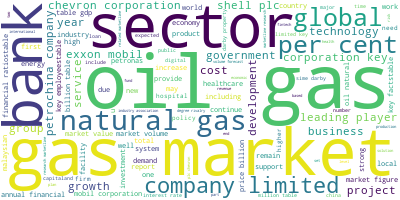

In [13]:
# Join the different processed titles together.
long_string = ','.join(list(df['Content'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [14]:
def get_top_n_words(n_top_words, text_data):
    '''
    Returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample

    Args:
    - n_top_words (int): Number of top words to retrieve
    - text_data (pandas.Series): Series containing text data
    
    Returns:
    - tuple: A tuple containing two elements:
             1. List of top n words
             2. List of counts corresponding to the top n words
    '''
    # Initialize CountVectorizer
    count_vectorizer = CountVectorizer(stop_words='english')
    
    # Vectorize the headlines
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    
    # Sum up the vectorized words
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    
    # Get indices of sorted words
    word_indices = np.flip(np.argsort(vectorized_total)[0, :], 1)
    
    # Get sorted word counts
    word_values = np.flip(np.sort(vectorized_total)[0, :], 1)
    
    # Initialize word vectors
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    
    # Populate word vectors
    for i in range(n_top_words):
        word_vectors[i, word_indices[0, i]] = 1

    # Get words from indices
    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0, :n_top_words].tolist()[0])


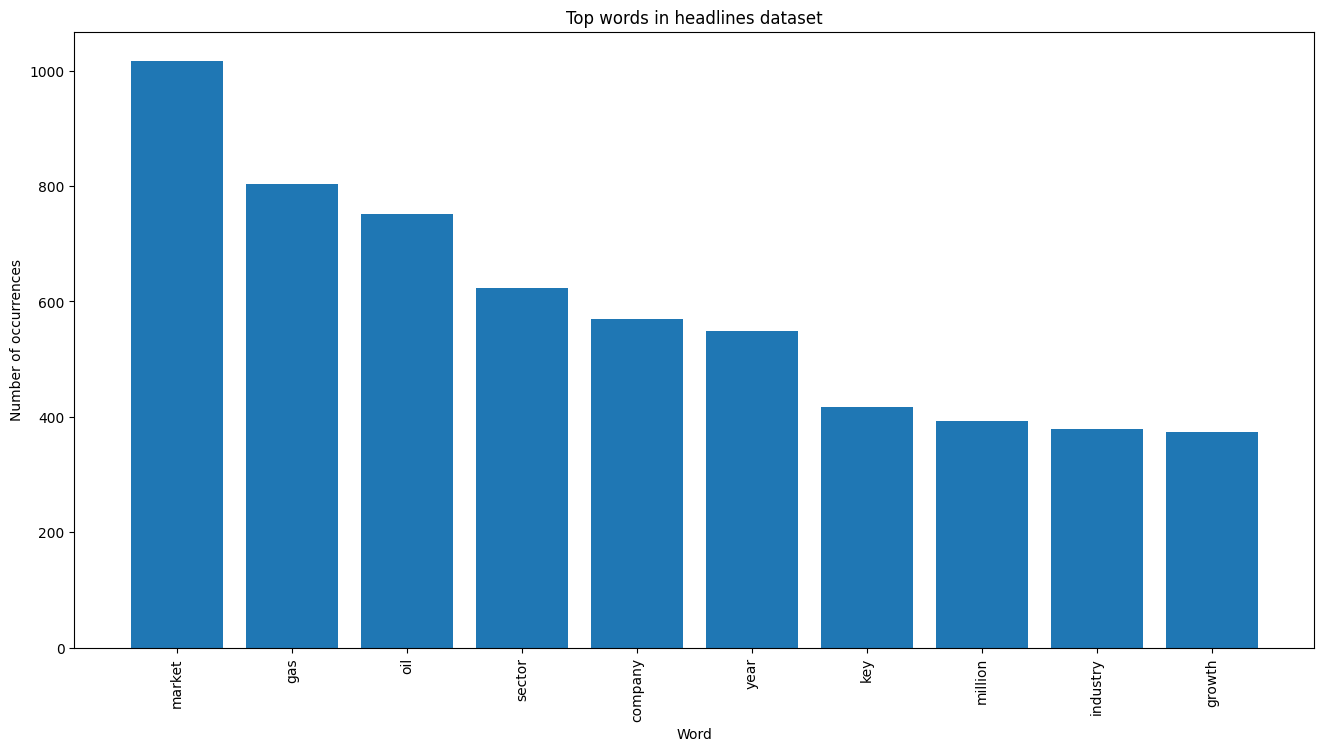

In [15]:
# Get the top n words and their counts
words, word_values = get_top_n_words(n_top_words=10, text_data=df['Content'])

# Plot the top words
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurrences')
plt.show()


`Sentiment Analysis`

In [16]:
def get_sentiments(sector_df, pretrained_model):
    """
    Analyzes the sentiment of a list of headlines using a pre-trained transformer model.

    Args:
        pretrained_model (str): Name of the pre-trained model from the Hugging Face model hub.

    Returns:
        dataFrame: A DataFrame containing the sentiment analysis results.

        """

    # Load pre-trained tokenizer and model for sentiment classification
    articles_array = np.array(sector_df['Content'])
    articles_list = list(articles_array)
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model)

    # Prepare text inputs with padding, truncation, and conversion to PyTorch tensors
    inputs = tokenizer(articles_list, padding=True, truncation=True, return_tensors="pt")

    # Get model predictions (logits) and apply softmax for probability distribution
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Create DataFrame to present sentiment analysis results using 'sentiment_dataframe' function
    #Headline #Positive #Negative #Neutral
    positive = predictions[:, 0].tolist()
    negative = predictions[:, 1].tolist()
    neutral = predictions[:, 2].tolist()    

    new_df = sector_df.copy()
    new_df['Positive'] = positive
    new_df['Negative'] = negative
    new_df['Neutral'] = neutral

    return new_df



In [17]:
sector_names = df.Sector.unique()
print(sector_names)

['Oil and Gas' 'Construction' 'Financials' 'Consumer Goods' 'Logistics'
 'Industrials' 'Healthcare' 'Technology' 'Real Estate' 'Media']


In [18]:
finbert_sentiments = pd.DataFrame()
financial_sentiments = pd.DataFrame()
sigma_sentiments = pd.DataFrame()
for s in sector_names:
  df1 = df.query("Sector == @s")
  finbert_temp = get_sentiments(df1,"ProsusAI/finbert")
  financial_temp = get_sentiments(df1,"mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
  sigma_temp = get_sentiments(df1,"Sigma/financial-sentiment-analysis")

  finbert_sentiments = pd.concat([finbert_sentiments, finbert_temp])
  financial_sentiments = pd.concat([financial_sentiments, financial_temp])
  sigma_sentiments = pd.concat([sigma_sentiments, sigma_temp])
 

In [19]:
def get_sentimentsII(row, pipeline):
    '''
    Analyzes the sentiment of a content row using a pre-defined sentiment analysis pipeline.

    Args:
    - row (pandas.Series): Row containing the content to analyze
    - pipeline: Pre-defined sentiment analysis pipeline

    Returns:
    - pandas.Series: Updated row with sentiment analysis results added as 'sentiment' and 'sentiment_score'
    '''
    # Extract content from the row
    content = row['Content']
    
    # Perform sentiment analysis using the provided pipeline
    result = pipeline(content)
    
    # Add sentiment analysis results to the row
    row['sentiment'] = result[0]['label']
    row['sentiment_score'] = result[0]['score']
    
    return row


In [20]:
# Define a sentiment analysis pipeline using the "soleimanian/financial-roberta-large-sentiment" model
soleimanian_pipeline = pipeline("sentiment-analysis", 
                                model="soleimanian/financial-roberta-large-sentiment", 
                                tokenizer="soleimanian/financial-roberta-large-sentiment", 
                                max_length=512, 
                                truncation=True)

# Define a sentiment analysis pipeline using the "yiyanghkust/finbert-tone" model
yiyangkhust_pipeline = pipeline("sentiment-analysis", 
                                model="yiyanghkust/finbert-tone", 
                                tokenizer="yiyanghkust/finbert-tone", 
                                max_length=512, 
                                truncation=True)


In [21]:
print(len(df))

142


In [22]:
soleimanian_sentiments = df.apply(get_sentimentsII, pipeline=soleimanian_pipeline, axis=1)
yiyangkhost_sentiments = df.apply(get_sentimentsII, pipeline=yiyangkhust_pipeline, axis=1)

In [23]:
print(len(soleimanian_sentiments))

142


In [24]:
def getSentimentLabel(row):
  Positive = row['Positive']
  Negative = row['Negative']
  Neutral = row['Neutral']
  
  if Positive > Negative and Positive > Neutral:
    return 'Positive'
  elif Negative > Positive and Negative > Neutral:
    return 'Negative'
  else:
    return 'Neutral'
  

In [25]:
financial_sentiments['sentiment'] = financial_sentiments.apply(getSentimentLabel, axis=1)
finbert_sentiments['sentiment'] = finbert_sentiments.apply(getSentimentLabel, axis=1)
sigma_sentiments['sentiment'] = sigma_sentiments.apply(getSentimentLabel, axis=1)

In [26]:
financial_sentiments.head()

,Title,Content,Site-Name,Sector,Country,Positive,Negative,Neutral,sentiment
0,"The three big Malaysian banks, Maybank, CIMB a...",news see whats happening bfsi sector right exc...,bfsi,Oil and Gas,Malaysia,0.000057,0.999795,0.000148,Negative
1,This article first appeared in The Edge Malays...,bank growing increasingly cautious granting lo...,edge,Oil and Gas,Malaysia,0.997853,0.000687,0.001460,Positive
2,ICLG - Oil & Gas Laws and Regulations -,chapter cover common issue oil gas law regulat...,iclg,Oil and Gas,Malaysia,0.000072,0.999861,0.000067,Negative
3,Articles & Commentaries >,iseas perspective article commentary iseas pe...,Iseas,Oil and Gas,Malaysia,0.005238,0.007906,0.986856,Neutral
4,The report covers Malaysia Oil and Gas Compani...,disclaimer major player sorted particular orde...,Mordor,Oil and Gas,Malaysia,0.000315,0.908571,0.091114,Negative


In [27]:
finbert_sentiments.head()

,Title,Content,Site-Name,Sector,Country,Positive,Negative,Neutral,sentiment
0,"The three big Malaysian banks, Maybank, CIMB a...",news see whats happening bfsi sector right exc...,bfsi,Oil and Gas,Malaysia,0.048134,0.018377,0.933489,Neutral
1,This article first appeared in The Edge Malays...,bank growing increasingly cautious granting lo...,edge,Oil and Gas,Malaysia,0.039409,0.835608,0.124983,Negative
2,ICLG - Oil & Gas Laws and Regulations -,chapter cover common issue oil gas law regulat...,iclg,Oil and Gas,Malaysia,0.041413,0.036411,0.922176,Neutral
3,Articles & Commentaries >,iseas perspective article commentary iseas pe...,Iseas,Oil and Gas,Malaysia,0.089104,0.020226,0.890670,Neutral
4,The report covers Malaysia Oil and Gas Compani...,disclaimer major player sorted particular orde...,Mordor,Oil and Gas,Malaysia,0.031972,0.027401,0.940627,Neutral


In [28]:
sigma_sentiments.head()

,Title,Content,Site-Name,Sector,Country,Positive,Negative,Neutral,sentiment
0,"The three big Malaysian banks, Maybank, CIMB a...",news see whats happening bfsi sector right exc...,bfsi,Oil and Gas,Malaysia,0.002548,0.987287,0.010165,Negative
1,This article first appeared in The Edge Malays...,bank growing increasingly cautious granting lo...,edge,Oil and Gas,Malaysia,0.413878,0.433051,0.153071,Negative
2,ICLG - Oil & Gas Laws and Regulations -,chapter cover common issue oil gas law regulat...,iclg,Oil and Gas,Malaysia,0.006746,0.968459,0.024795,Negative
3,Articles & Commentaries >,iseas perspective article commentary iseas pe...,Iseas,Oil and Gas,Malaysia,0.016048,0.911215,0.072737,Negative
4,The report covers Malaysia Oil and Gas Compani...,disclaimer major player sorted particular orde...,Mordor,Oil and Gas,Malaysia,0.027593,0.832523,0.139884,Negative


In [29]:
soleimanian_sentiments.head()

,Title,Content,Site-Name,Sector,Country,sentiment,sentiment_score
0,"The three big Malaysian banks, Maybank, CIMB a...",news see whats happening bfsi sector right exc...,bfsi,Oil and Gas,Malaysia,neutral,0.999026
1,This article first appeared in The Edge Malays...,bank growing increasingly cautious granting lo...,edge,Oil and Gas,Malaysia,negative,0.998877
2,ICLG - Oil & Gas Laws and Regulations -,chapter cover common issue oil gas law regulat...,iclg,Oil and Gas,Malaysia,neutral,0.999512
3,Articles & Commentaries >,iseas perspective article commentary iseas pe...,Iseas,Oil and Gas,Malaysia,neutral,0.998640
4,The report covers Malaysia Oil and Gas Compani...,disclaimer major player sorted particular orde...,Mordor,Oil and Gas,Malaysia,neutral,0.999593


In [30]:
def combine_sentiments_score(df, model_name, models, column_name="sentiment"):
  """_summary_

  Args:
      df (_type_): _description_
      column_name (str, optional): _description_. Defaults to "sentiment".
  """
  columns = ["Positive", "Negative", "Neutral"]
  i = 0
  for model in models:
    name = model_name[i]
    sentiment_result = model[column_name]
    for label in columns:
      replacement = model[label]
      df[f'{name}_{label}'] = replacement
    df[f'{name}_sentiment'] = sentiment_result
    i+=1
  return df
  

In [31]:
model_name = ["financial", "finbert", "sigma"]
models = [financial_sentiments, finbert_sentiments, sigma_sentiments]
df_combined_scores = df.copy()
df_combined_scores = combine_sentiments_score(df_combined_scores, model_name, models)
df_combined_scores.head(5)

,Title,Content,Site-Name,Sector,Country,financial_Positive,financial_Negative,financial_Neutral,financial_sentiment,finbert_Positive,finbert_Negative,finbert_Neutral,finbert_sentiment,sigma_Positive,sigma_Negative,sigma_Neutral,sigma_sentiment
0,"The three big Malaysian banks, Maybank, CIMB a...",news see whats happening bfsi sector right exc...,bfsi,Oil and Gas,Malaysia,0.000057,0.999795,0.000148,Negative,0.048134,0.018377,0.933489,Neutral,0.002548,0.987287,0.010165,Negative
1,This article first appeared in The Edge Malays...,bank growing increasingly cautious granting lo...,edge,Oil and Gas,Malaysia,0.997853,0.000687,0.001460,Positive,0.039409,0.835608,0.124983,Negative,0.413878,0.433051,0.153071,Negative
2,ICLG - Oil & Gas Laws and Regulations -,chapter cover common issue oil gas law regulat...,iclg,Oil and Gas,Malaysia,0.000072,0.999861,0.000067,Negative,0.041413,0.036411,0.922176,Neutral,0.006746,0.968459,0.024795,Negative
3,Articles & Commentaries >,iseas perspective article commentary iseas pe...,Iseas,Oil and Gas,Malaysia,0.005238,0.007906,0.986856,Neutral,0.089104,0.020226,0.890670,Neutral,0.016048,0.911215,0.072737,Negative
4,The report covers Malaysia Oil and Gas Compani...,disclaimer major player sorted particular orde...,Mordor,Oil and Gas,Malaysia,0.000315,0.908571,0.091114,Negative,0.031972,0.027401,0.940627,Neutral,0.027593,0.832523,0.139884,Negative


In [32]:
df_combined_scores.isna().sum()

Title                  0
Content                0
Site-Name              0
Sector                 0
Country                0
financial_Positive     0
financial_Negative     0
financial_Neutral      0
financial_sentiment    0
finbert_Positive       0
finbert_Negative       0
finbert_Neutral        0
finbert_sentiment      0
sigma_Positive         0
sigma_Negative         0
sigma_Neutral          0
sigma_sentiment        0
dtype: int64

In [33]:
financial_sentiments

,Title,Content,Site-Name,Sector,Country,Positive,Negative,Neutral,sentiment
0,"The three big Malaysian banks, Maybank, CIMB a...",news see whats happening bfsi sector right exc...,bfsi,Oil and Gas,Malaysia,0.000057,0.999795,0.000148,Negative
1,This article first appeared in The Edge Malays...,bank growing increasingly cautious granting lo...,edge,Oil and Gas,Malaysia,0.997853,0.000687,0.001460,Positive
2,ICLG - Oil & Gas Laws and Regulations -,chapter cover common issue oil gas law regulat...,iclg,Oil and Gas,Malaysia,0.000072,0.999861,0.000067,Negative
3,Articles & Commentaries >,iseas perspective article commentary iseas pe...,Iseas,Oil and Gas,Malaysia,0.005238,0.007906,0.986856,Neutral
4,The report covers Malaysia Oil and Gas Compani...,disclaimer major player sorted particular orde...,Mordor,Oil and Gas,Malaysia,0.000315,0.908571,0.091114,Negative
...,...,...,...,...,...,...,...,...,...
102,J’den by CapitaLand Development is Singapore’s...,prospective homebuyers j den waiting number ca...,CapitaLand,Real Estate,Singapore,0.000271,0.000297,0.999433,Neutral
103,OCBC Bank Partners CapitaLand On Singapore's F...,june ocbc bank capitaland inked first loan f...,CapitaLand,Real Estate,Singapore,0.000072,0.999816,0.000112,Negative
104,UOB collaborates with CapitaLand on Singapore’...,september united overseas bank limited uob c...,CapitaLand,Real Estate,Singapore,0.000182,0.000836,0.998982,Neutral
113,Singapore Media overview,medium market expected experience significant ...,thestar,Media,Singapore,0.000240,0.000183,0.999577,Neutral


In [34]:
def combine_sentiments(df, column_name="sentiment"):
  '''
  Combines sentiment analysis results from different models into a single DataFrame.

  Args:
  - sentiments_dict (dict): Dictionary containing DataFrames of sentiment analysis results

  Returns:
  - DataFrame: Combined DataFrame containing sentiment analysis results from different models
  '''
  sentiments_dict = {
    "Financial_Sentiments": financial_sentiments,
    "Finbert_Sentiments": finbert_sentiments,
    "Sigma_Sentiments": sigma_sentiments,
    "Soleimanian_Sentiments": soleimanian_sentiments,
    "Yiyangkhost_Sentiments": yiyangkhost_sentiments
  }
    
  map_dict = {
    "Neutral": 0,
    "Positive": 1,
    "Negative": -1,
    'neutral' : 0,
    'positive' : 1,
    'negative' : -1,
    0: 0,
    1: 1,
    -1: -1
  }
  
  for key, value in sentiments_dict.items():
    
    replacement = value[column_name].map(map_dict)
    df[key] = replacement
  return df
  

In [35]:
df_combined = df.copy()
df_combined = combine_sentiments(df_combined)
df_combined.head(5)

,Title,Content,Site-Name,Sector,Country,Financial_Sentiments,Finbert_Sentiments,Sigma_Sentiments,Soleimanian_Sentiments,Yiyangkhost_Sentiments
0,"The three big Malaysian banks, Maybank, CIMB a...",news see whats happening bfsi sector right exc...,bfsi,Oil and Gas,Malaysia,-1,0,-1,0,0
1,This article first appeared in The Edge Malays...,bank growing increasingly cautious granting lo...,edge,Oil and Gas,Malaysia,1,-1,-1,-1,0
2,ICLG - Oil & Gas Laws and Regulations -,chapter cover common issue oil gas law regulat...,iclg,Oil and Gas,Malaysia,-1,0,-1,0,0
3,Articles & Commentaries >,iseas perspective article commentary iseas pe...,Iseas,Oil and Gas,Malaysia,0,0,-1,0,0
4,The report covers Malaysia Oil and Gas Compani...,disclaimer major player sorted particular orde...,Mordor,Oil and Gas,Malaysia,-1,0,-1,0,0


In [36]:
df_combined.isna().sum()

Title                     0
Content                   0
Site-Name                 0
Sector                    0
Country                   0
Financial_Sentiments      0
Finbert_Sentiments        0
Sigma_Sentiments          0
Soleimanian_Sentiments    0
Yiyangkhost_Sentiments    0
dtype: int64

In [37]:
financial_sentiments['sentiment'].value_counts().values.tolist()

[107, 19, 16]

`Visualization`

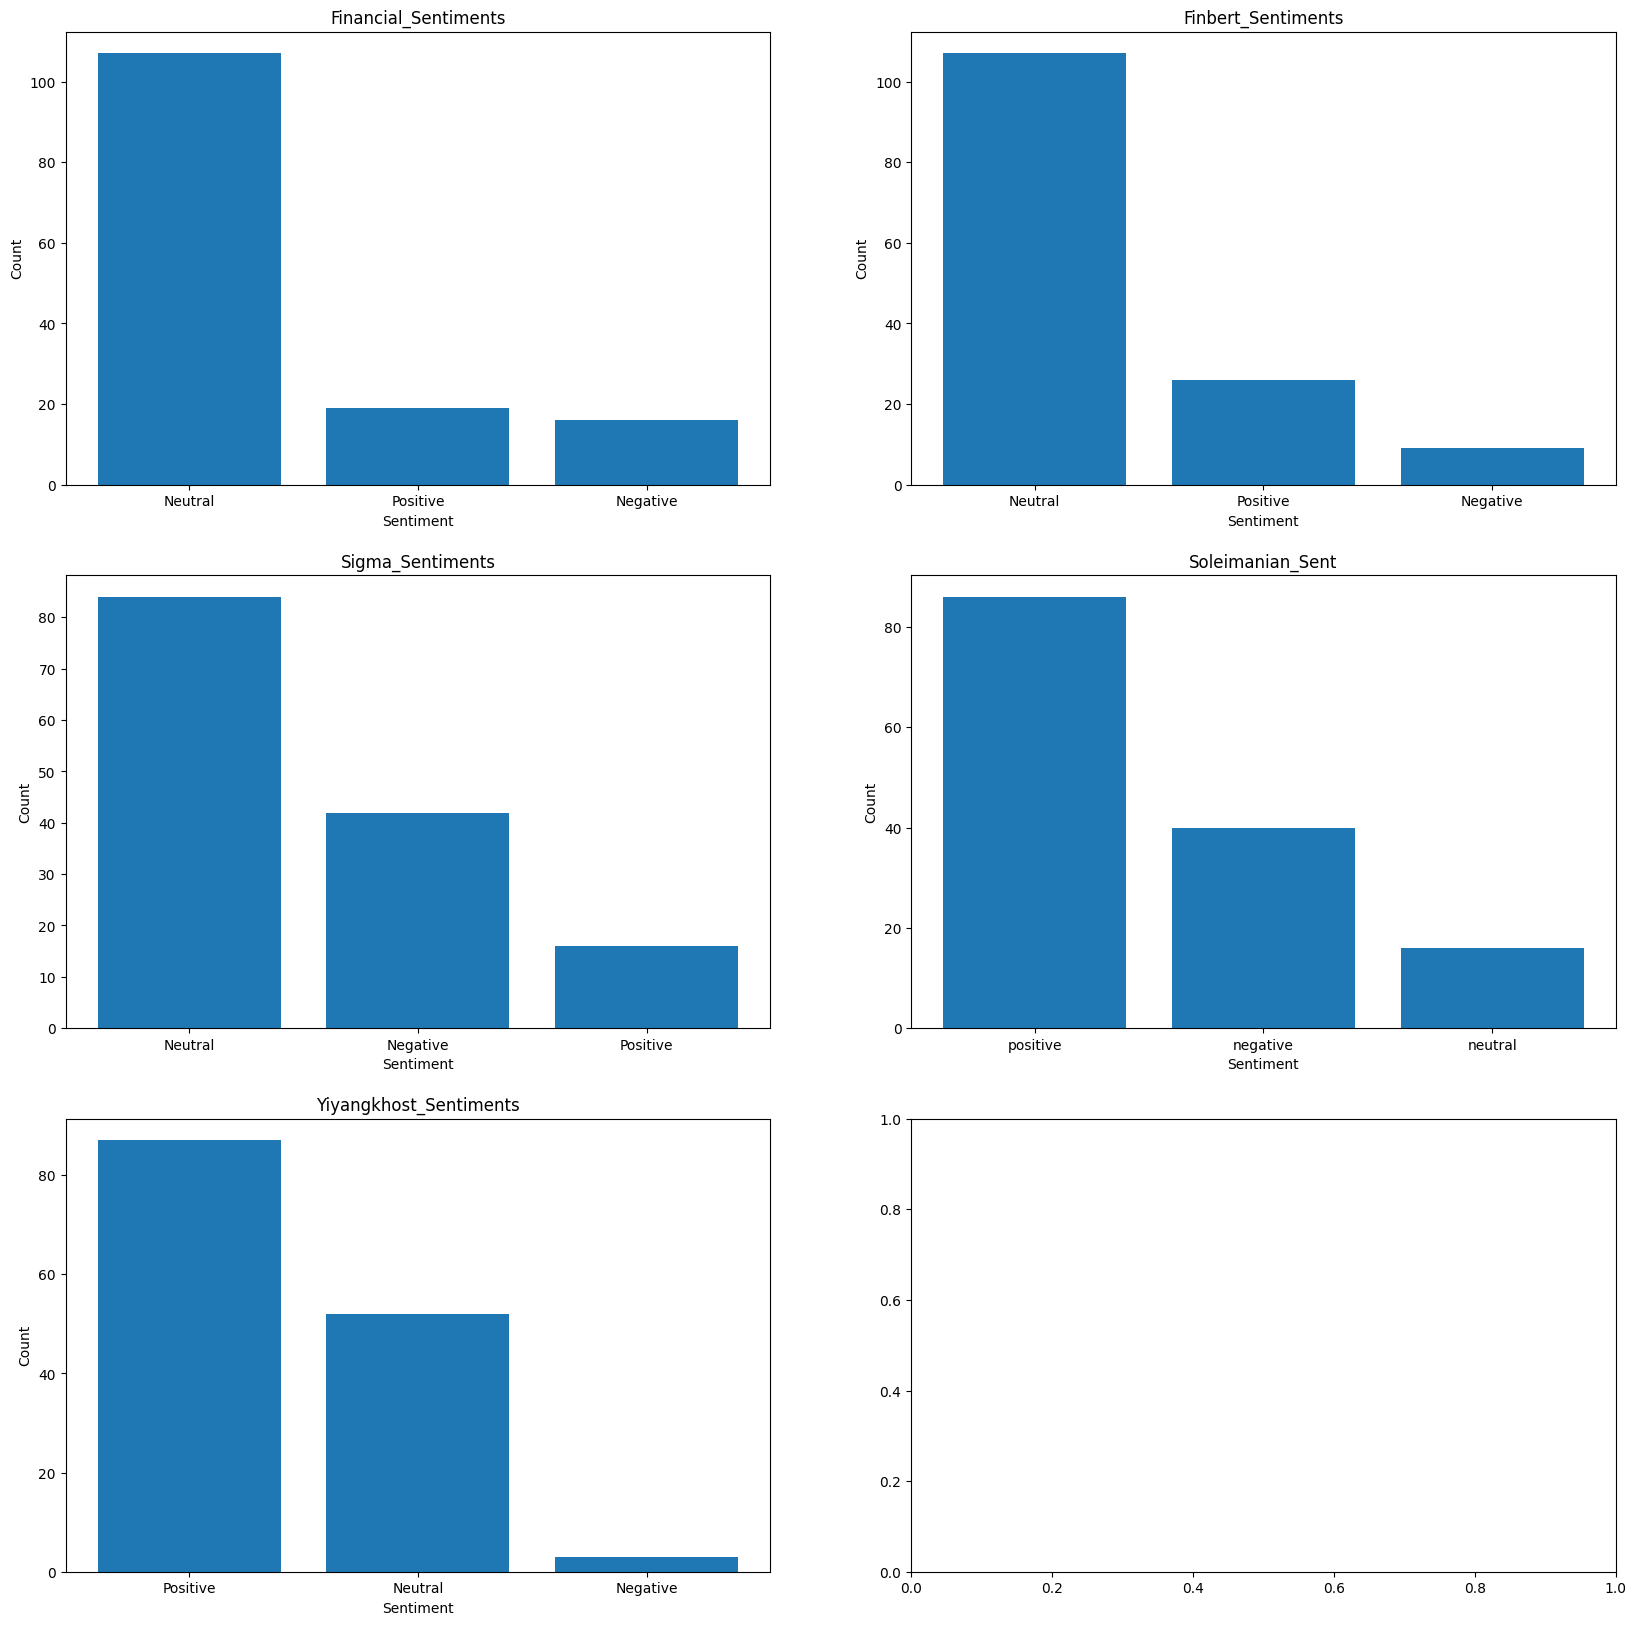

In [38]:
plt.subplots(3,2, figsize=(20, 20))

models = [financial_sentiments, finbert_sentiments, sigma_sentiments, soleimanian_sentiments, yiyangkhost_sentiments]
models_name = ['Financial_Sentiments', 'Finbert_Sentiments', 'Sigma_Sentiments', 'Soleimanian_Sent', 'Yiyangkhost_Sentiments']

# plot bar plot for each model

for i in range(len(models)):
  plt.subplot(3, 2, i+1)
  plt.bar(models[i]['sentiment'].value_counts().index, models[i]['sentiment'].value_counts().values)
  plt.title(models_name[i])
  plt.xlabel('Sentiment')
  plt.ylabel('Count')


In [39]:
map_dict = {
  "Neutral": 0,
  "Positive": 1,
  "Negative": -1,
  'neutral' : 0,
  'positive' : 1,
  'negative' : -1
}
# Encode the sentiment labels
dataframes = [financial_sentiments, finbert_sentiments, sigma_sentiments, soleimanian_sentiments, yiyangkhost_sentiments]

for dataframe in dataframes : 
    dataframe['sentiment'] = dataframe['sentiment'].map(map_dict)


In [40]:
def horizontalStackedBar(results, category_names, title="Sentiment Analysis Results"):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    
    
    
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(10, 7))
    
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
 
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    ax.set_title(title, loc = 'right')
    return fig, ax

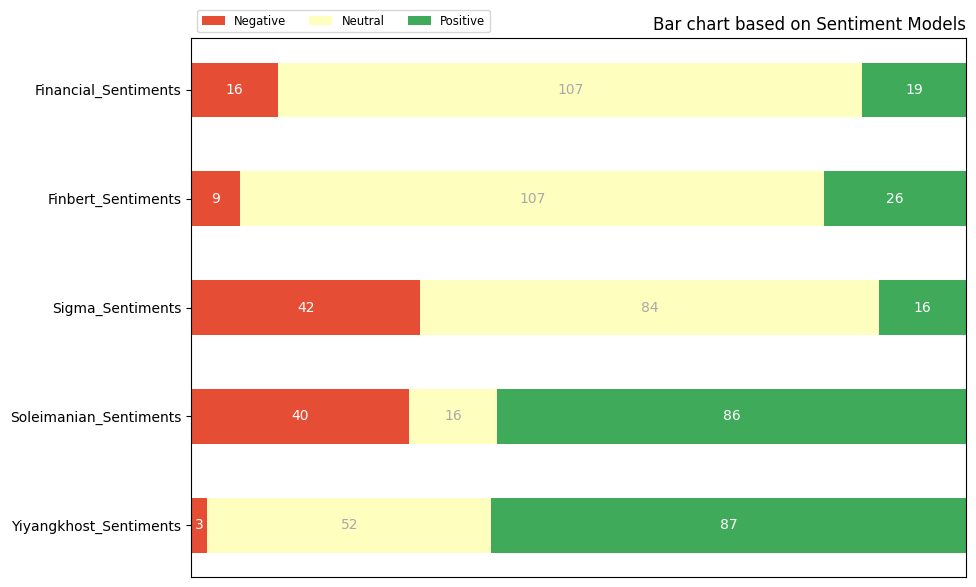

In [41]:
import matplotlib.pyplot as plt
import numpy as np

category_names = ['Negative', 'Neutral', 'Positive']

models_name = ['Financial_Sentiments', 'Finbert_Sentiments', 'Sigma_Sentiments', 'Soleimanian_Sentiments', 'Yiyangkhost_Sentiments']
models = [financial_sentiments, finbert_sentiments, sigma_sentiments, soleimanian_sentiments, yiyangkhost_sentiments]

results = dict()

for i in range(len(models)):
  # make it so that it will follow the order
  model_list = []
  model_dict = models[i]['sentiment'].value_counts().to_dict()
  model_list.append(model_dict[-1]); model_list.append(model_dict[0]); model_list.append(model_dict[1])
  results[models_name[i]] = model_list


horizontalStackedBar(results, category_names, title="Bar chart based on Sentiment Models")

plt.show()

/var/folders/y_/8gyd3ykj37j086_rbgg_6yn00000gn/T/ipykernel_3549/2702960220.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


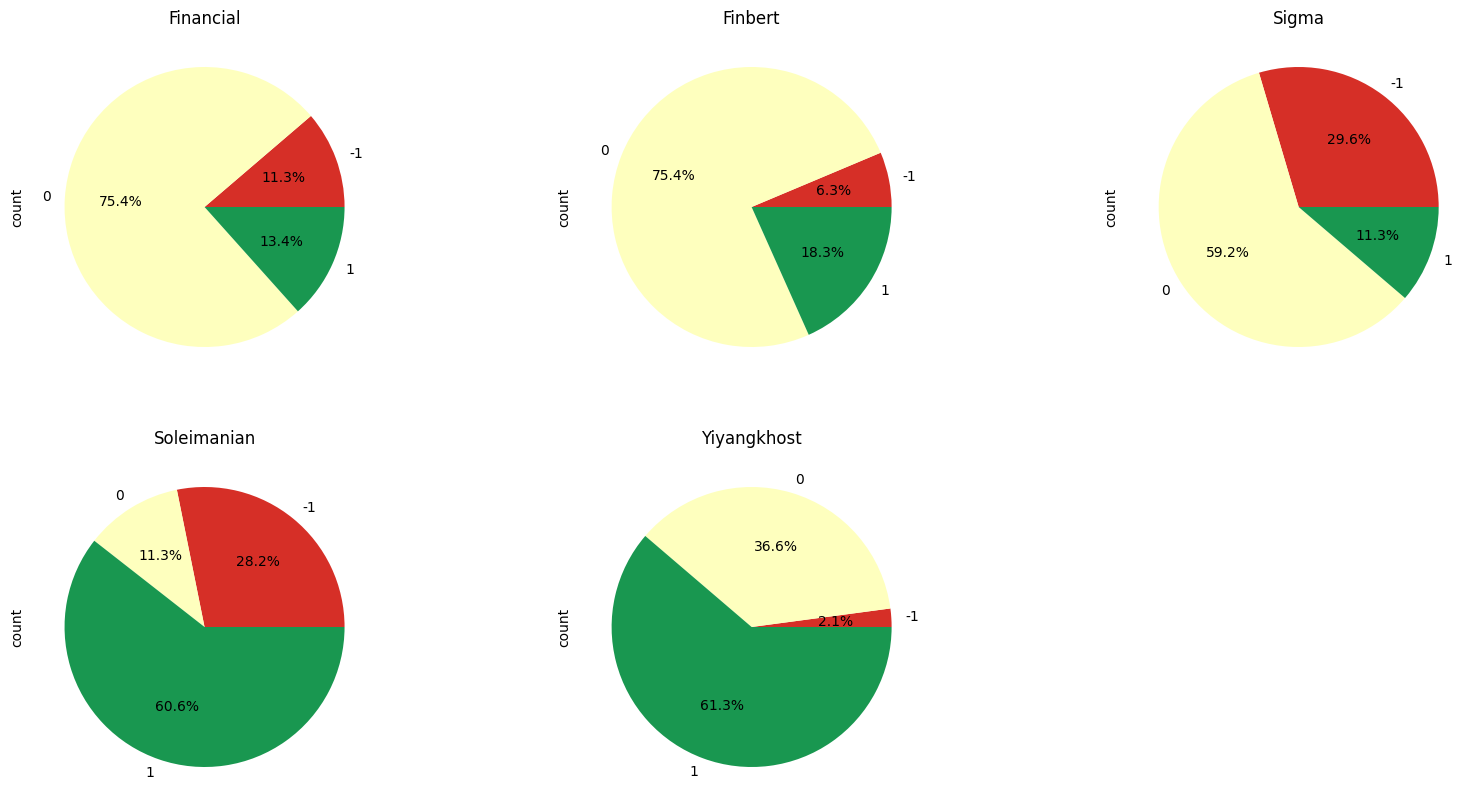

In [42]:
fig, ax = plt.subplots(2,3, figsize=(20,10))

# make a pie chart for each dataframe
dataframes = [financial_sentiments, finbert_sentiments, sigma_sentiments, soleimanian_sentiments, yiyangkhost_sentiments]
titles = ['Financial', 'Finbert', 'Sigma', 'Soleimanian', 'Yiyangkhost']

cmap = plt.cm.get_cmap('RdYlGn')
colors = {1: cmap(0.9), 0: cmap(0.5), -1: cmap(0.1)}

for i, df in enumerate(dataframes):
  row = i // 3
  col = i % 3
  sentiment_counts = df['sentiment'].value_counts().sort_index()
  sentiment_colors = [colors[sentiment] for sentiment in sentiment_counts.index]
  sentiment_counts.plot(kind='pie', ax=ax[row, col], autopct='%1.1f%%', colors=sentiment_colors)
  ax[row][col].set_title(titles[i])


fig.delaxes(ax[1, 2])
ax[1][2].legend()

`Based on the graphs above, we will choose Financial, Finbert, and Sigma as our sentiment model`

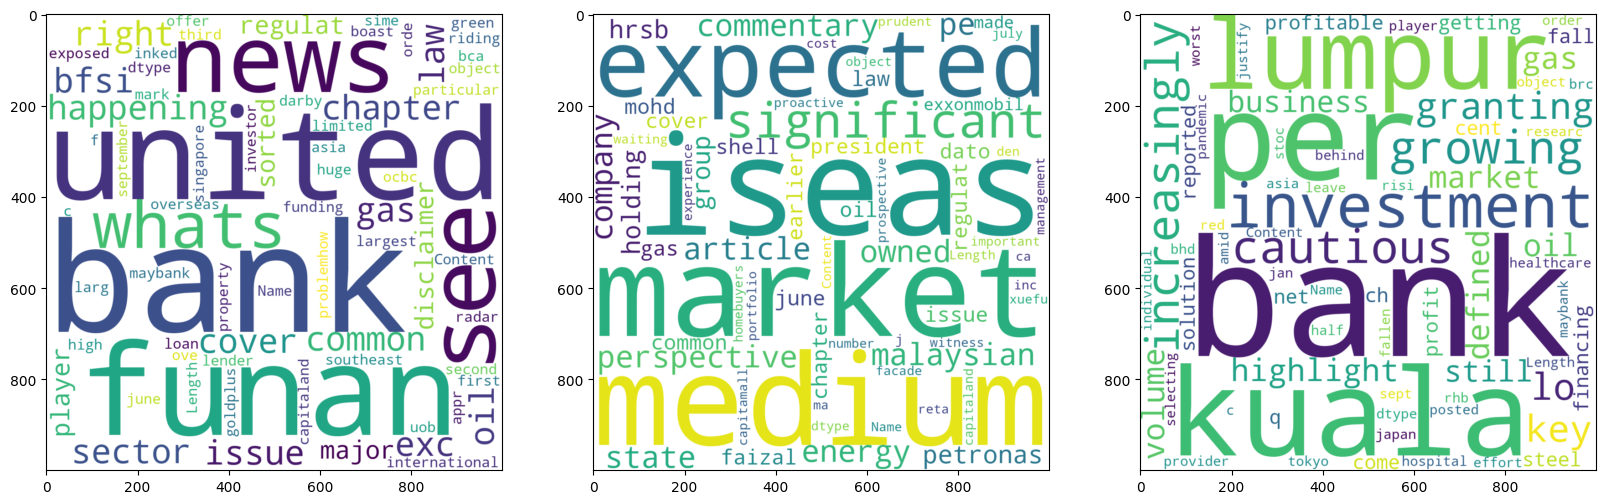

In [43]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

positive_financial = financial_sentiments[financial_sentiments['sentiment'] == 1]
positive_finbert = finbert_sentiments[finbert_sentiments['sentiment'] == 1]
positive_sigma = sigma_sentiments[sigma_sentiments['sentiment'] == 1]

# create a new dataframe
positive_dataframe = pd.concat([positive_financial, positive_finbert, positive_sigma])

positive_dataframe.dropna(inplace=True)

positive_wordcloud = WordCloud(width = 1000, height = 1000,
                background_color ='white',
                min_font_size = 10).generate(''.join(str(positive_dataframe['Content'])))

neutral_financial = financial_sentiments[financial_sentiments['sentiment'] == 0]
neutral_finbert = finbert_sentiments[finbert_sentiments['sentiment'] == 0]
neutral_sigma = sigma_sentiments[sigma_sentiments['sentiment'] == 0]

neutral_dataframe = pd.concat([neutral_financial, neutral_finbert, neutral_sigma])
neutral_dataframe.dropna(inplace=True)
neutral_wordcloud = WordCloud(width = 1000, height = 1000,
                background_color ='white',
                min_font_size = 10).generate(''.join(str(neutral_dataframe['Content'])))



negative_financial = financial_sentiments[financial_sentiments['sentiment'] == -1]
negative_finbert = finbert_sentiments[finbert_sentiments['sentiment'] == -1]
negative_sigma = sigma_sentiments[sigma_sentiments['sentiment'] == -1]

negative_dataframe = pd.concat([negative_financial, negative_finbert, negative_sigma])
negative_dataframe.dropna(inplace=True)
negative_wordcloud = WordCloud(width = 1000, height = 1000,
                background_color ='white',
                min_font_size = 10).generate(''.join(str(negative_dataframe['Content'])))


fig, ax = plt.subplots(1, 3, figsize=(20, 20))
# wordcloud on 0 0
ax[0].imshow(negative_wordcloud, interpolation='bilinear')
ax[1].imshow(neutral_wordcloud, interpolation='bilinear')
ax[2].imshow(positive_wordcloud, interpolation='bilinear')
plt.show()

`Function to help visualizations`

In [44]:
def get_results_for_model(model, column_name="Sector"):
  result = dict()
  sectors = model[column_name].unique()
  
  for s in sectors:
    subset = model.query("Sector == @s")
    positive = subset[subset['sentiment'] == 1]
    negative = subset[subset['sentiment'] == -1]
    neutral = subset[subset['sentiment'] == 0]
    result[s] = [len(negative), len(neutral), len(positive)]
  return result

In [45]:
def custom_autopct(pct):
  return ('%1.1f%%' % pct) if pct > 0 else ''

`Financial Sentiments`

/var/folders/y_/8gyd3ykj37j086_rbgg_6yn00000gn/T/ipykernel_3549/467525815.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')


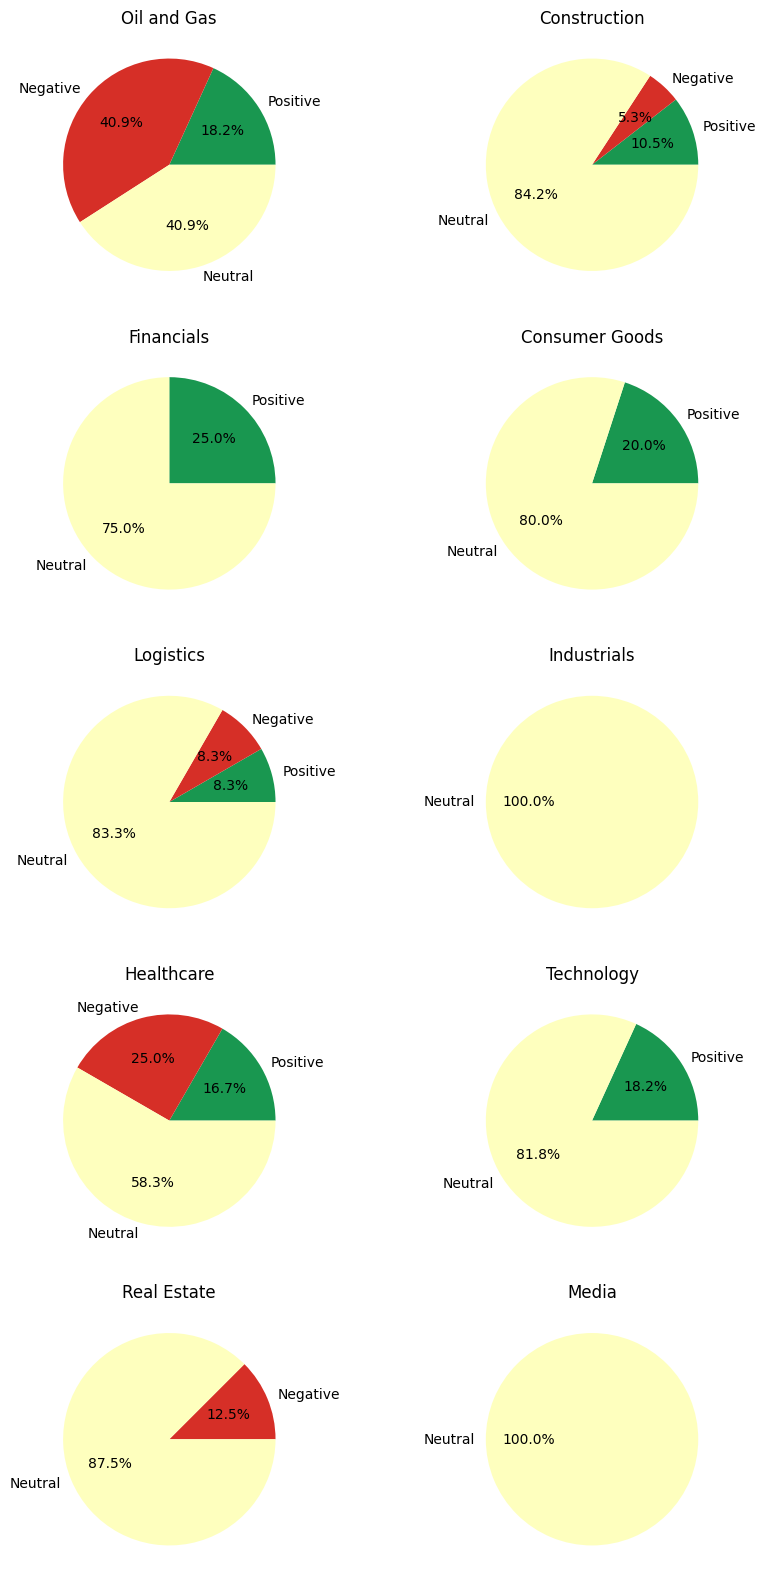

In [46]:
# make visualization per sector for financial_sentiments
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

cmap = plt.cm.get_cmap('RdYlGn')
colors = {1: cmap(0.9), 0: cmap(0.5), -1: cmap(0.1)}


for s in sector_names:
  row = sector_names.tolist().index(s) // 2
  col = sector_names.tolist().index(s) % 2
  subset = financial_sentiments.query("Sector == @s")
  positive = subset[subset['sentiment'] == 1]
  negative = subset[subset['sentiment'] == -1]
  neutral = subset[subset['sentiment'] == 0]
  labels = ['Positive', 'Negative', 'Neutral']
  labels = [label if count > 0 else '' for label, count in zip(labels, [len(positive), len(negative), len(neutral)])]

  # make pie chart
  sentiment_colors = [colors[sentiment] for sentiment in [1, -1, 0]]
  ax[row, col].pie([len(positive), len(negative), len(neutral)], labels=labels, autopct=custom_autopct, colors=sentiment_colors)
  ax[row, col].set_title(s)

plt.show()
  

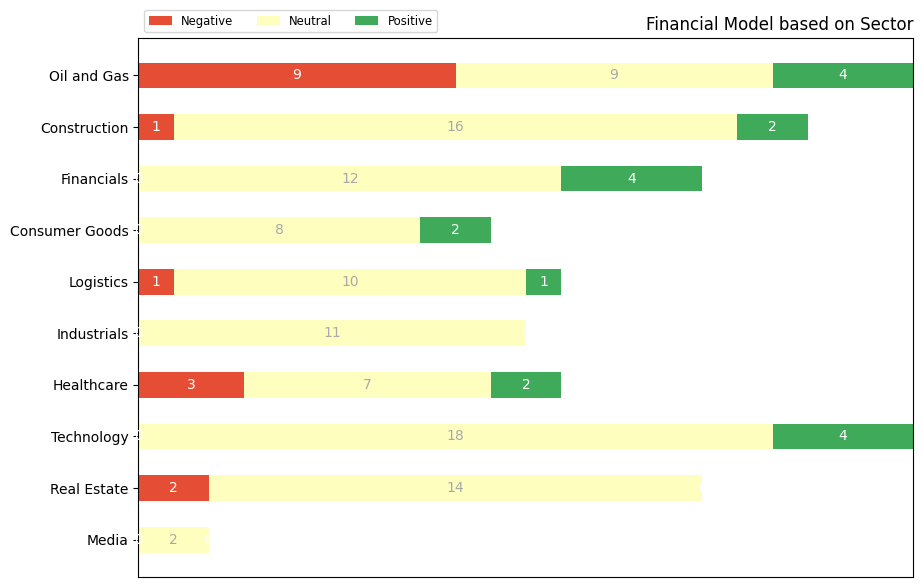

In [47]:
financial_results = get_results_for_model(financial_sentiments, 'Sector')
horizontalStackedBar(financial_results, category_names, title="Financial Model based on Sector")
plt.show()

`Finbert`

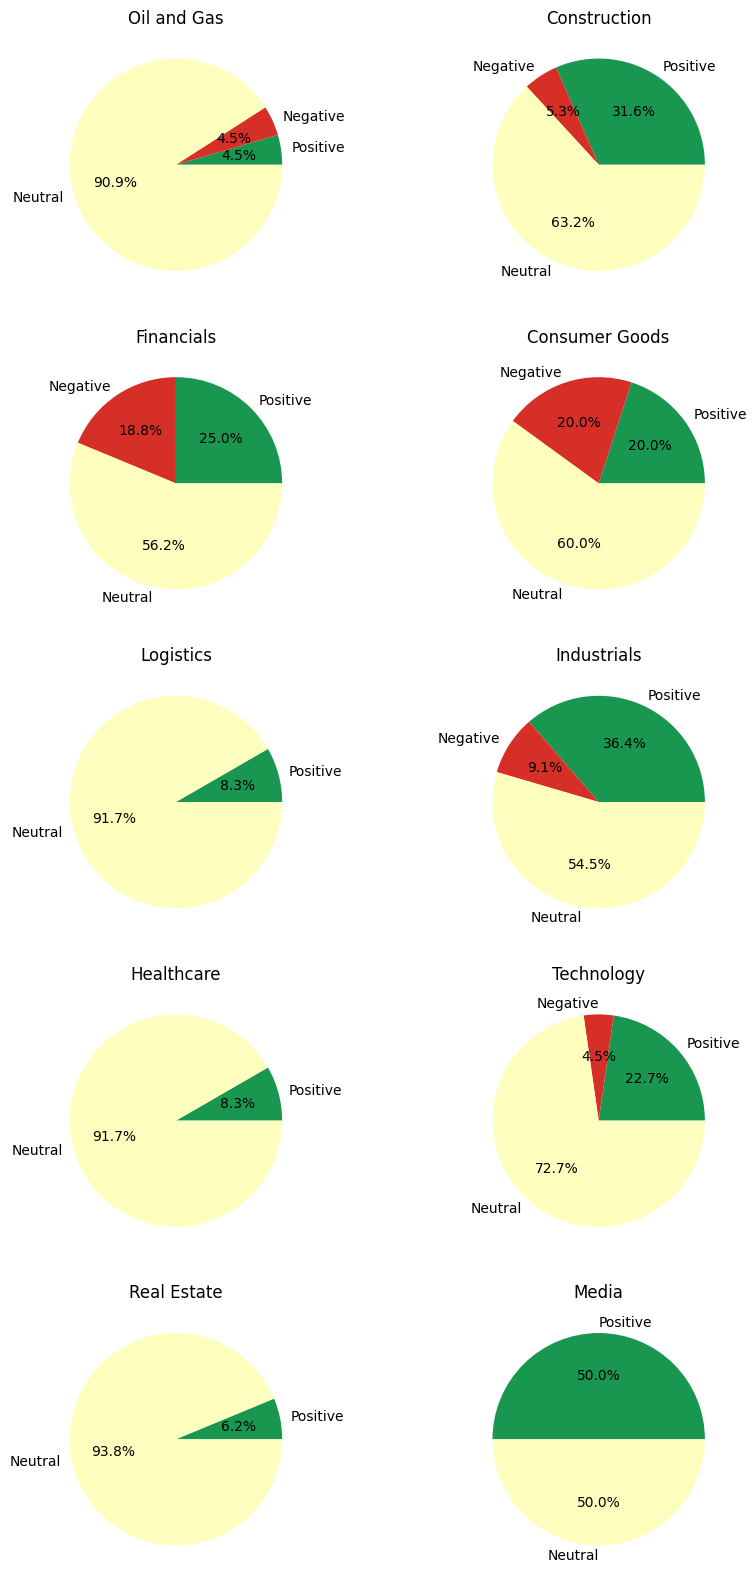

In [48]:
# make visualization per sector for financial_sentiments
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for s in sector_names:
  row = sector_names.tolist().index(s) // 2
  col = sector_names.tolist().index(s) % 2
  subset = finbert_sentiments.query("Sector == @s")
  positive = subset[subset['sentiment'] == 1]
  negative = subset[subset['sentiment'] == -1]
  neutral = subset[subset['sentiment'] == 0]
  labels = ['Positive', 'Negative', 'Neutral']
  labels = [label if count > 0 else '' for label, count in zip(labels, [len(positive), len(negative), len(neutral)])]

  # make pie chart
  sentiment_colors = [colors[sentiment] for sentiment in [1, -1, 0]]
  ax[row, col].pie([len(positive), len(negative), len(neutral)], labels=labels, autopct=custom_autopct, colors = sentiment_colors)
  ax[row, col].set_title(s)

plt.show()
  

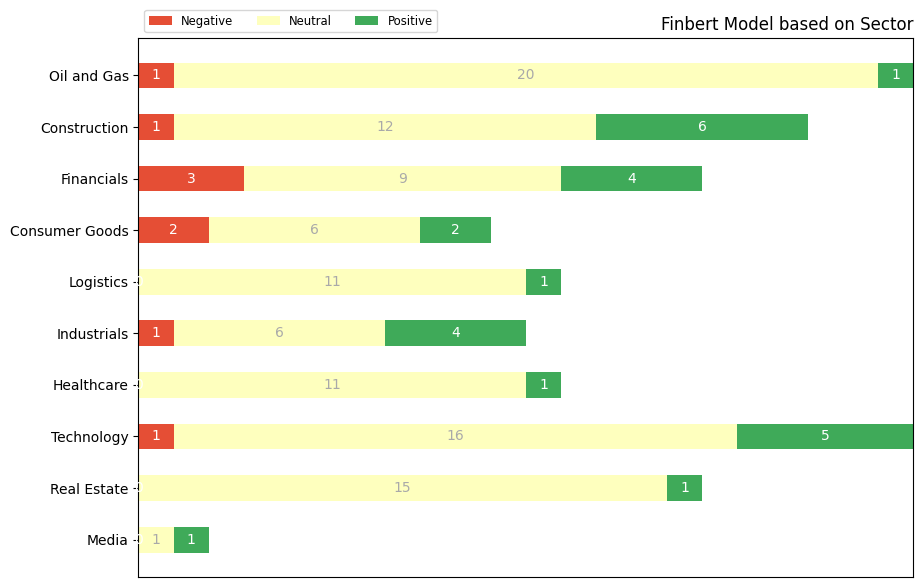

In [49]:
finbert_results = get_results_for_model(finbert_sentiments, 'Sector')
horizontalStackedBar(finbert_results, category_names, title="Finbert Model based on Sector")
plt.show()

`Sigma`

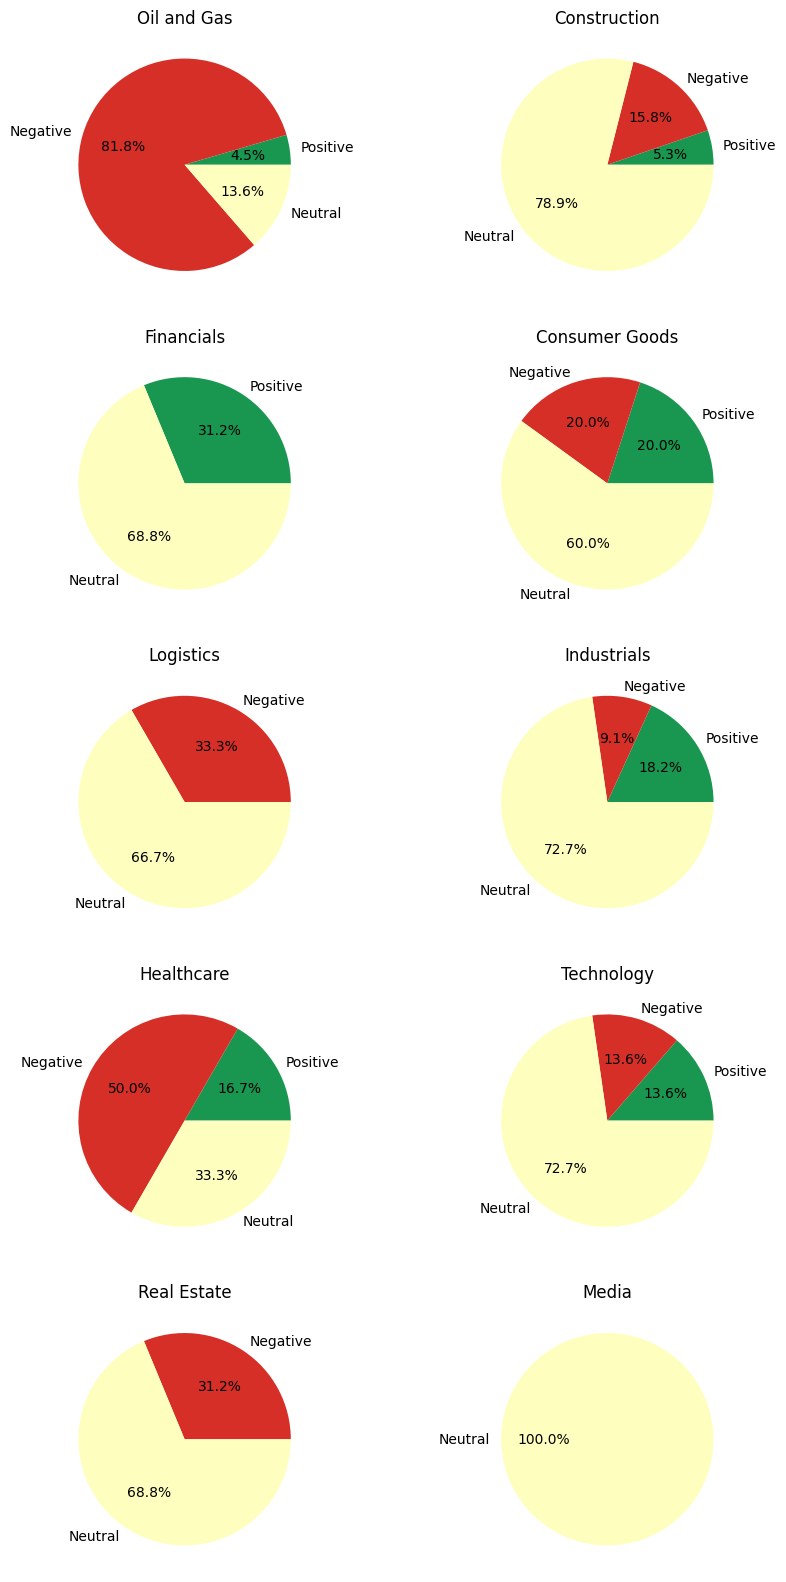

In [50]:
# make visualization per sector for financial_sentiments
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for s in sector_names:
  row = sector_names.tolist().index(s) // 2
  col = sector_names.tolist().index(s) % 2
  subset = sigma_sentiments.query("Sector == @s")
  positive = subset[subset['sentiment'] == 1]
  negative = subset[subset['sentiment'] == -1]
  neutral = subset[subset['sentiment'] == 0]
  labels = ['Positive', 'Negative', 'Neutral']
  labels = [label if count > 0 else '' for label, count in zip(labels, [len(positive), len(negative), len(neutral)])]
  # make pie chart
  sentiment_colors = [colors[sentiment] for sentiment in [1, -1, 0]]
  ax[row, col].pie([len(positive), len(negative), len(neutral)], labels=labels, autopct=custom_autopct, colors = sentiment_colors)
  ax[row, col].set_title(s)

plt.show()
  

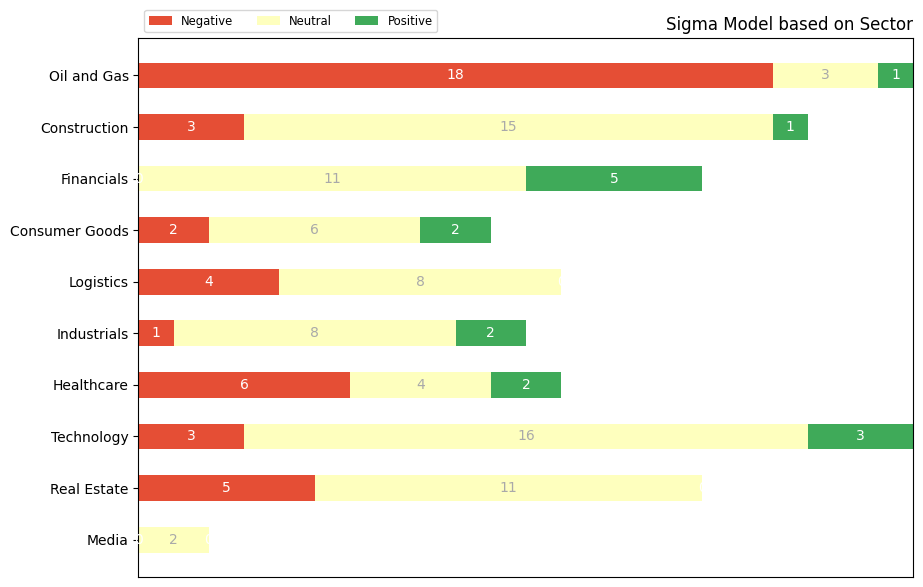

In [51]:
sigma_results = get_results_for_model(sigma_sentiments, 'Sector')
horizontalStackedBar(sigma_results, category_names, title="Sigma Model based on Sector")
plt.show()

In [52]:
# export combined dataframe into csv
df_combined.to_csv('combined_sentiments.csv', index=False)
financial_sentiments.to_csv('financial_sentiments.csv', index=False)
finbert_sentiments.to_csv('finbert_sentiments.csv', index=False)
sigma_sentiments.to_csv('sigma_sentiments.csv', index=False)
soleimanian_sentiments.to_csv('soleimanian_sentiments.csv', index=False)
yiyangkhost_sentiments.to_csv('yiyangkhost_sentiments.csv', index=False)